# **Job Market Analysis using NLP**

*Objective: Analyze AI risk with NLP in jobs using their job descriptions, required skills, knowledge*

Dataset:
Job postings scraped from online job portals.

Techniques:
- Text preprocessing
- NLP-based keyword extraction
- Exploratory data analysis


# File Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler

#for NLP 
import re
import string
from nltk.corpus import stopwords
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

#for embeddings and clustering
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#for topic modeling
from bertopic import BERTopic

pd.set_option('display.max_columns', None)

# Data Collection & Exploration

In [5]:
occupation_df = pd.read_csv("/Users/dev/Documents/Projects/AI Risk Analysis of Job Roles using NLP/data/db/Occupation_Data.csv")
skills_df = pd.read_csv("/Users/dev/Documents/Projects/AI Risk Analysis of Job Roles using NLP/data/db/Skills.csv")
knowledge_df = pd.read_csv("/Users/dev/Documents/Projects/AI Risk Analysis of Job Roles using NLP/data/db/Knowledge.csv")
abilities_df = pd.read_csv('/Users/dev/Documents/Projects/AI Risk Analysis of Job Roles using NLP/data/db/Abilities.csv')

onet_29_merged = pd.read_csv('/Users/dev/Documents/Projects/AI Risk Analysis of Job Roles using NLP/data/ONET_29_Merged_Data.csv')
print(onet_29_merged.shape)
print(occupation_df.shape)
print(skills_df.shape)
print(knowledge_df.shape)
print(abilities_df.shape)


(1016, 123)
(1016, 3)
(61530, 13)
(58014, 13)
(91416, 13)


In [6]:
skills_pivot = skills_df.pivot_table(
    index=["O*NET-SOC Code", "Element ID", "Element Name"],
    columns="Scale ID",
    values="Data Value",
    aggfunc="first"
).reset_index()

skills_pivot = skills_pivot.rename(columns={"IM": "Importance", "LV": "Level"})
print(f"Skills shape: {skills_pivot.shape}")

knowledge_pivot = knowledge_df.pivot_table(
    index=["O*NET-SOC Code", "Element ID", "Element Name"],
    columns="Scale ID",
    values="Data Value",
    aggfunc="first"
).reset_index()

knowledge_pivot = knowledge_pivot.rename(columns={"IM": "Importance", "LV": "Level"})
print(f"Knowledge shape: {knowledge_pivot.shape}")

abilities_pivot = abilities_df.pivot_table(
    index=["O*NET-SOC Code", "Element ID", "Element Name"],
    columns="Scale ID",
    values="Data Value",
    aggfunc="first"
).reset_index()

abilities_pivot = abilities_pivot.rename(columns={"IM": "Importance", "LV": "Level"})
print(f"Abilities shape: {abilities_pivot.shape}")

Skills shape: (30765, 5)
Knowledge shape: (29007, 5)
Abilities shape: (45708, 5)


In [7]:
skills_with_titles = pd.merge(
    skills_pivot,
    occupation_df[["O*NET-SOC Code", "Title", "Description"]],
    on="O*NET-SOC Code",
    how="left"
)
print(skills_with_titles.shape)

knowledge_with_titles = pd.merge(
    knowledge_pivot,
    occupation_df[["O*NET-SOC Code", "Title", "Description"]],
    on="O*NET-SOC Code",
    how="left"
)
print(knowledge_with_titles.shape)

abilities_with_titles = pd.merge(
    abilities_pivot,
    occupation_df[["O*NET-SOC Code", "Title", "Description"]],
    on="O*NET-SOC Code",
    how="left"
)
print(abilities_with_titles.shape)

(30765, 7)
(29007, 7)
(45708, 7)


### Group Top 10 Skill for Every Job

In [8]:
top_skills = (
    skills_with_titles.sort_values(by=["O*NET-SOC Code", "Importance"], ascending=False)
    .groupby(["O*NET-SOC Code", "Title", "Description"])
    .head(10)
)
top_knowledge = (
    knowledge_with_titles.sort_values(by=["O*NET-SOC Code", "Importance"], ascending=False)
    .groupby(["O*NET-SOC Code", "Title", "Description"])
    .head(10)
)
top_abilities = (
    abilities_with_titles.sort_values(by=["O*NET-SOC Code", "Importance"], ascending=False)
    .groupby(["O*NET-SOC Code", "Title", "Description"])
    .head(10)
)

In [9]:
role_docs_skills = (
    top_skills.groupby(["O*NET-SOC Code", "Title", "Description"])["Element Name"]
    .apply(lambda skills: ", ".join(skills))
    .reset_index()
    .rename(columns={"Element Name": "Skill Profile"})
)
level_stats = (
    top_skills.groupby("O*NET-SOC Code")["Level"]
    .agg(["mean", "max", "min"])
    .reset_index()
    .rename(columns={"mean": "avg_level", "max": "max_level", "min": "min_level"})
)

role_docs_with_skills = pd.merge(role_docs_skills, level_stats, on="O*NET-SOC Code", how="left")
print(role_docs_with_skills.shape)

role_docs_with_skills.drop(columns=["Description","avg_level","max_level","min_level"], inplace=True)
role_docs_with_skills.head()

(879, 7)


,O*NET-SOC Code,Title,Skill Profile
0,11-1011.00,Chief Executives,"Judgment and Decision Making, Critical Thinkin..."
1,11-1011.03,Chief Sustainability Officers,"Writing, Critical Thinking, Reading Comprehens..."
2,11-1021.00,General and Operations Managers,"Reading Comprehension, Active Listening, Speak..."
3,11-2011.00,Advertising and Promotions Managers,"Active Listening, Speaking, Critical Thinking,..."
4,11-2021.00,Marketing Managers,"Reading Comprehension, Active Listening, Speak..."


In [10]:
role_docs_knowledge = (
    top_knowledge.groupby(["O*NET-SOC Code", "Title", "Description"])["Element Name"]
    .apply(lambda knowledge: ", ".join(knowledge))
    .reset_index()
    .rename(columns={"Element Name": "Knowledge Profile"})
)
level_stats = (
    top_skills.groupby("O*NET-SOC Code")["Level"]
    .agg(["mean", "max", "min"])
    .reset_index()
    .rename(columns={"mean": "avg_level", "max": "max_level", "min": "min_level"})
)

role_docs_with_knowledge = pd.merge(role_docs_knowledge, level_stats, on="O*NET-SOC Code", how="left")
print(role_docs_with_knowledge.shape)

role_docs_with_knowledge.drop(columns=["Description","avg_level","max_level","min_level"], inplace=True)
role_docs_with_knowledge.head()

(879, 7)


,O*NET-SOC Code,Title,Knowledge Profile
0,11-1011.00,Chief Executives,"Administration and Management, Personnel and H..."
1,11-1011.03,Chief Sustainability Officers,"English Language, Administration and Managemen..."
2,11-1021.00,General and Operations Managers,"Administration and Management, Customer and Pe..."
3,11-2011.00,Advertising and Promotions Managers,"Sales and Marketing, English Language, Communi..."
4,11-2021.00,Marketing Managers,"Sales and Marketing, English Language, Adminis..."


In [11]:
role_docs_abilities = (
    top_abilities.groupby(["O*NET-SOC Code", "Title", "Description"])["Element Name"]
    .apply(lambda abilities: ", ".join(abilities))
    .reset_index()
    .rename(columns={"Element Name": "Ability Profile"})
)
level_stats = (
    top_skills.groupby("O*NET-SOC Code")["Level"]
    .agg(["mean", "max", "min"])
    .reset_index()
    .rename(columns={"mean": "avg_level", "max": "max_level", "min": "min_level"})
)

role_docs_with_abilities = pd.merge(role_docs_abilities, level_stats, on="O*NET-SOC Code", how="left")
print(role_docs_with_abilities.shape)
role_docs_with_abilities.head()

role_docs_with_abilities.drop(columns=["Description","avg_level","max_level","min_level"], inplace=True)
role_docs_with_abilities.head()

(879, 7)


,O*NET-SOC Code,Title,Ability Profile
0,11-1011.00,Chief Executives,"Oral Comprehension, Oral Expression, Written C..."
1,11-1011.03,Chief Sustainability Officers,"Written Expression, Oral Comprehension, Writte..."
2,11-1021.00,General and Operations Managers,"Oral Comprehension, Written Comprehension, Ora..."
3,11-2011.00,Advertising and Promotions Managers,"Oral Expression, Oral Comprehension, Written C..."
4,11-2021.00,Marketing Managers,"Oral Comprehension, Written Comprehension, Ora..."


In [12]:
role_docs_with_skills_knowledge = pd.merge(role_docs_with_skills, role_docs_with_knowledge, on="O*NET-SOC Code", how="left") 
role_docs_with_skills_knowledge_abilities = pd.merge(role_docs_with_skills_knowledge, role_docs_with_abilities, on="O*NET-SOC Code", how="left")
print(role_docs_with_skills_knowledge_abilities.shape)
role_docs_with_skills_knowledge_abilities.drop(columns=["Title_x","Title_y","Title"], inplace=True) 
role_docs_with_skills_knowledge_abilities.head()   

(879, 7)


,O*NET-SOC Code,Skill Profile,Knowledge Profile,Ability Profile
0,11-1011.00,"Judgment and Decision Making, Critical Thinkin...","Administration and Management, Personnel and H...","Oral Comprehension, Oral Expression, Written C..."
1,11-1011.03,"Writing, Critical Thinking, Reading Comprehens...","English Language, Administration and Managemen...","Written Expression, Oral Comprehension, Writte..."
2,11-1021.00,"Reading Comprehension, Active Listening, Speak...","Administration and Management, Customer and Pe...","Oral Comprehension, Written Comprehension, Ora..."
3,11-2011.00,"Active Listening, Speaking, Critical Thinking,...","Sales and Marketing, English Language, Communi...","Oral Expression, Oral Comprehension, Written C..."
4,11-2021.00,"Reading Comprehension, Active Listening, Speak...","Sales and Marketing, English Language, Adminis...","Oral Comprehension, Written Comprehension, Ora..."


In [13]:
df_main = pd.merge(onet_29_merged,role_docs_with_skills_knowledge_abilities ,how="inner", on="O*NET-SOC Code")
df_main.drop(columns=["O*NET-SOC Code"], inplace=True)
print(df_main.shape)
df_main.to_csv('main_dataset_with_num.csv', index=False)
df_main.head()


(879, 125)


,Title,Description,Skill: Active Learning,Skill: Active Listening,Skill: Complex Problem Solving,Skill: Coordination,Skill: Critical Thinking,Skill: Equipment Maintenance,Skill: Equipment Selection,Skill: Installation,Skill: Instructing,Skill: Judgment and Decision Making,Skill: Learning Strategies,Skill: Management of Financial Resources,Skill: Management of Material Resources,Skill: Management of Personnel Resources,Skill: Mathematics,Skill: Monitoring,Skill: Negotiation,Skill: Operation and Control,Skill: Operations Analysis,Skill: Operations Monitoring,Skill: Persuasion,Skill: Programming,Skill: Quality Control Analysis,Skill: Reading Comprehension,Skill: Repairing,Skill: Science,Skill: Service Orientation,Skill: Social Perceptiveness,Skill: Speaking,Skill: Systems Analysis,Skill: Systems Evaluation,Skill: Technology Design,Skill: Time Management,Skill: Troubleshooting,Skill: Writing,Knowledge: Administration and Management,Knowledge: Administrative,Knowledge: Biology,Knowledge: Building and Construction,Knowledge: Chemistry,Knowledge: Communications and Media,Knowledge: Computers and Electronics,Knowledge: Customer and Personal Service,Knowledge: Design,Knowledge: Economics and Accounting,Knowledge: Education and Training,Knowledge: Engineering and Technology,Knowledge: English Language,Knowledge: Fine Arts,Knowledge: Food Production,Knowledge: Foreign Language,Knowledge: Geography,Knowledge: History and Archeology,Knowledge: Law and Government,Knowledge: Mathematics,Knowledge: Mechanical,Knowledge: Medicine and Dentistry,Knowledge: Personnel and Human Resources,Knowledge: Philosophy and Theology,Knowledge: Physics,Knowledge: Production and Processing,Knowledge: Psychology,Knowledge: Public Safety and Security,Knowledge: Sales and Marketing,Knowledge: Sociology and Anthropology,Knowledge: Telecommunications,Knowledge: Therapy and Counseling,Knowledge: Transportation,Ability: Arm-Hand Steadiness,Ability: Auditory Attention,Ability: Category Flexibility,Ability: Control Precision,Ability: Deductive Reasoning,Ability: Depth Perception,Ability: Dynamic Flexibility,Ability: Dynamic Strength,Ability: Explosive Strength,Ability: Extent Flexibility,Ability: Far Vision,Ability: Finger Dexterity,Ability: Flexibility of Closure,Ability: Fluency of Ideas,Ability: Glare Sensitivity,Ability: Gross Body Coordination,Ability: Gross Body Equilibrium,Ability: Hearing Sensitivity,Ability: Inductive Reasoning,Ability: Information Ordering,Ability: Manual Dexterity,Ability: Mathematical Reasoning,Ability: Memorization,Ability: Multilimb Coordination,Ability: Near Vision,Ability: Night Vision,Ability: Number Facility,Ability: Oral Comprehension,Ability: Oral Expression,Ability: Originality,Ability: Perceptual Speed,Ability: Peripheral Vision,Ability: Problem Sensitivity,Ability: Rate Control,Ability: Reaction Time,Ability: Response Orientation,Ability: Selective Attention,Ability: Sound Localization,Ability: Spatial Orientation,Ability: Speech Clarity,Ability: Speech Recognition,Ability: Speed of Closure,Ability: Speed of Limb Movement,Ability: Stamina,Ability: Static Strength,Ability: Time Sharing,Ability: Trunk Strength,Ability: Visual Color Discrimination,Ability: Visualization,Ability: Wrist-Finger Speed,Ability: Written Comprehension,Ability: Written Expression,Skill Profile,Knowledge Profile,Ability Profile
0,Chief Executives,Determine and formulate policies and provide o...,3.75,4.00,4.38,4.25,4.38,1.0,1.12,1.0,3.38,4.75,3.12,4.25,4.00,4.25,3.25,4.00,4.12,1.88,3.12,2.00,4.00,1.75,1.88,4.12,1.0,1.62,3.12,4.12,4.25,4.12,4.25,1.75,4.00,1.50,4.12,4.78,2.42,1.74,1.83,1.69,3.02,3.82,4.39,1.91,4.04,3.52,3.05,4.41,1.70,1.14,2.26,2.69,2.16,3.48,3.60,2.10,1.51,4.48,2.35,2.01,2.71,3.09,3.88,3.81,2.88,2.59,1.87,2.26,1.38,2.12,3.50,1.75,4.12,1.75,1.0,1.25,1.00,1.00,3.00,1.50,3.25,3.88,1.25,1.0,1.00,2.12,4.00,4.00,1.00,3.25,2.88,1.75,3.62,1.25,3.12,4.62,4.50,3.75,3.00,1.25,4.00,1.38,1.38,1.38,3.00,1.38,1.38,4.25,4.00,3.00,1.0,1.00,1.0,2.88,1.38,2.00,

# Data Preprocessing

In [14]:
df_main.isnull().sum().sum()
df_main.duplicated().sum()

0

## Word Joing For Further Embedding

In [15]:
df_text = df_main[['Title', 'Description', 'Skill Profile','Knowledge Profile','Ability Profile']]
df_main['corpus'] = df_text['Title'].str.lower() + ' is a job whose key responsibility is to ' + df_text['Description'].str.lower() + '. the required skills are ' + df_text['Skill Profile'].str.lower() + '. the required knowledge is ' + df_text['Knowledge Profile'].str.lower() + '. the required abilities are ' + df_text['Ability Profile'].str.lower()
df_text.head()

,Title,Description,Skill Profile,Knowledge Profile,Ability Profile
0,Chief Executives,Determine and formulate policies and provide o...,"Judgment and Decision Making, Critical Thinkin...","Administration and Management, Personnel and H...","Oral Comprehension, Oral Expression, Written C..."
1,Chief Sustainability Officers,"Communicate and coordinate with management, sh...","Writing, Critical Thinking, Reading Comprehens...","English Language, Administration and Managemen...","Written Expression, Oral Comprehension, Writte..."
2,General and Operations Managers,"Plan, direct, or coordinate the operations of ...","Reading Comprehension, Active Listening, Speak...","Administration and Management, Customer and Pe...","Oral Comprehension, Written Comprehension, Ora..."
3,Advertising and Promotions Managers,"Plan, direct, or coordinate advertising polici...","Active Listening, Speaking, Critical Thinking,...","Sales and Marketing, English Language, Communi...","Oral Expression, Oral Comprehension, Written C..."
4,Marketing Managers,"Plan, direct, or coordinate marketing policies...","Reading Comprehension, Active Listening, Speak...","Sales and Marketing, English Language, Adminis...","Oral Comprehension, Written Comprehension, Ora..."


#### *Columns Rearrangement for better visualisation*

In [ ]:
# Get all columns
cols = df_main.columns.tolist()


# Remove skill_profile and corpus from their current positions
cols.remove('Skill Profile')
cols.remove('Knowledge Profile')
cols.remove('Ability Profile')
cols.remove('corpus')



# Insert them at positions 3 and 4
cols.insert(2, 'Skill Profile')
cols.insert(3, 'Knowledge Profile')
cols.insert(4, 'Ability Profile')
cols.insert(5, 'corpus')

# Reorder the dataframe
df_main = df_main[cols]
df_main.head()

,Title,Description,Skill Profile,Knowledge Profile,Ability Profile,corpus,Skill: Active Learning,Skill: Active Listening,Skill: Complex Problem Solving,Skill: Coordination,Skill: Critical Thinking,Skill: Equipment Maintenance,Skill: Equipment Selection,Skill: Installation,Skill: Instructing,Skill: Judgment and Decision Making,Skill: Learning Strategies,Skill: Management of Financial Resources,Skill: Management of Material Resources,Skill: Management of Personnel Resources,Skill: Mathematics,Skill: Monitoring,Skill: Negotiation,Skill: Operation and Control,Skill: Operations Analysis,Skill: Operations Monitoring,Skill: Persuasion,Skill: Programming,Skill: Quality Control Analysis,Skill: Reading Comprehension,Skill: Repairing,Skill: Science,Skill: Service Orientation,Skill: Social Perceptiveness,Skill: Speaking,Skill: Systems Analysis,Skill: Systems Evaluation,Skill: Technology Design,Skill: Time Management,Skill: Troubleshooting,Skill: Writing,Knowledge: Administration and Management,Knowledge: Administrative,Knowledge: Biology,Knowledge: Building and Construction,Knowledge: Chemistry,Knowledge: Communications and Media,Knowledge: Computers and Electronics,Knowledge: Customer and Personal Service,Knowledge: Design,Knowledge: Economics and Accounting,Knowledge: Education and Training,Knowledge: Engineering and Technology,Knowledge: English Language,Knowledge: Fine Arts,Knowledge: Food Production,Knowledge: Foreign Language,Knowledge: Geography,Knowledge: History and Archeology,Knowledge: Law and Government,Knowledge: Mathematics,Knowledge: Mechanical,Knowledge: Medicine and Dentistry,Knowledge: Personnel and Human Resources,Knowledge: Philosophy and Theology,Knowledge: Physics,Knowledge: Production and Processing,Knowledge: Psychology,Knowledge: Public Safety and Security,Knowledge: Sales and Marketing,Knowledge: Sociology and Anthropology,Knowledge: Telecommunications,Knowledge: Therapy and Counseling,Knowledge: Transportation,Ability: Arm-Hand Steadiness,Ability: Auditory Attention,Ability: Category Flexibility,Ability: Control Precision,Ability: Deductive Reasoning,Ability: Depth Perception,Ability: Dynamic Flexibility,Ability: Dynamic Strength,Ability: Explosive Strength,Ability: Extent Flexibility,Ability: Far Vision,Ability: Finger Dexterity,Ability: Flexibility of Closure,Ability: Fluency of Ideas,Ability: Glare Sensitivity,Ability: Gross Body Coordination,Ability: Gross Body Equilibrium,Ability: Hearing Sensitivity,Ability: Inductive Reasoning,Ability: Information Ordering,Ability: Manual Dexterity,Ability: Mathematical Reasoning,Ability: Memorization,Ability: Multilimb Coordination,Ability: Near Vision,Ability: Night Vision,Ability: Number Facility,Ability: Oral Comprehension,Ability: Oral Expression,Ability: Originality,Ability: Perceptual Speed,Ability: Peripheral Vision,Ability: Problem Sensitivity,Ability: Rate Control,Ability: Reaction Time,Ability: Response Orientation,Ability: Selective Attention,Ability: Sound Localization,Ability: Spatial Orientation,Ability: Speech Clarity,Ability: Speech Recognition,Ability: Speed of Closure,Ability: Speed of Limb Movement,Ability: Stamina,Ability: Static Strength,Ability: Time Sharing,Ability: Trunk Strength,Ability: Visual Color Discrimination,Ability: Visualization,Ability: Wrist-Finger Speed,Ability: Written Comprehension,Ability: Written Expression
0,Chief Executives,Determine and formulate policies and provide o...,"Judgment and Decision Making, Critical Thinkin...","Administration and Management, Personnel and H...","Oral Comprehension, Oral Expression, Written C...",chief executives is a job whose key responsibi...,3.75,4.00,4.38,4.25,4.38,1.0,1.12,1.0,3.38,4.75,3.12,4.25,4.00,4.25,3.25,4.00,4.12,1.88,3.12,2.00,4.00,1.75,1.88,4.12,1.0,1.62,3.12,4.12,4.25,4.12,4.25,1.75,4.00,1.50,4.12,4.78,2.42,1.74,1.83,1.69,3.02,3.82,4.39,1.91,4.04,3.52,3.05,4.41,1.70,1.14,2.26,2.69,2.16,3.48,3.60,2.10,1.51,4.48,2.35,2.01,2.71,3.09,3.88,3.81,2.88,2.59,1.87,2.26,1.38,2.12,3.50,1.75,4.1

### Stop Words Removal

In [17]:
# Download stopwords once
nltk.download('stopwords')

STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lowercasing and Short Words Removal

In [18]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()

    # remove symbols & punctuation (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)

    # tokenize
    words = text.split()

    # remove stopwords & short words (<2)
    words = [
        w for w in words
        if w not in STOP_WORDS and len(w) >= 2
    ]

    return " ".join(words)

In [19]:
df_main_cleaned = df_main.copy()
df_main_cleaned['cleaned'] = df_main_cleaned['corpus'].apply(clean_text)

print(f"Main Corpus  : {df_main['corpus'][20]}")
print(f"Cleaned Text : {df_main_cleaned['cleaned'][20]}")


Main Corpus  : supply chain managers is a job whose key responsibility is to direct or coordinate production, purchasing, warehousing, distribution, or financial forecasting services or activities to limit costs and improve accuracy, customer service, or safety. examine existing procedures or opportunities for streamlining activities to meet product distribution needs. direct the movement, storage, or processing of inventory.. the required skills are reading comprehension, active listening, speaking, monitoring, coordination, judgment and decision making, time management, writing, critical thinking, complex problem solving. the required knowledge is transportation, administration and management, english language, economics and accounting, customer and personal service, production and processing, personnel and human resources, mathematics, computers and electronics, sales and marketing. the required abilities are oral comprehension, written comprehension, oral expression, written expres

### Lemmitization

In [20]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def lemmatize_text(text):
    if pd.isna(text) or text.strip() == "":
        return ""

    doc = nlp(text)
    lemmas = [
        token.lemma_
        for token in doc
        if token.is_alpha
        and not token.is_stop
        and token.pos_ in {"NOUN", "VERB"}
        and len(token) > 2
    ]
    return " ".join(lemmas)

In [21]:
df_lemmatized = df_main_cleaned.copy()
df_lemmatized['lemmatized_text'] = df_main_cleaned['cleaned'].apply(lemmatize_text)


print(f"Main Corpus     : {df_main['corpus'][20]}")
print(f"Cleaned Text    : {df_main_cleaned['cleaned'][20]}")
print(f"Lemmatized Text : {df_lemmatized['lemmatized_text'][20]}")

Main Corpus     : supply chain managers is a job whose key responsibility is to direct or coordinate production, purchasing, warehousing, distribution, or financial forecasting services or activities to limit costs and improve accuracy, customer service, or safety. examine existing procedures or opportunities for streamlining activities to meet product distribution needs. direct the movement, storage, or processing of inventory.. the required skills are reading comprehension, active listening, speaking, monitoring, coordination, judgment and decision making, time management, writing, critical thinking, complex problem solving. the required knowledge is transportation, administration and management, english language, economics and accounting, customer and personal service, production and processing, personnel and human resources, mathematics, computers and electronics, sales and marketing. the required abilities are oral comprehension, written comprehension, oral expression, written exp

# Feature Engineering

In [22]:
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(df_lemmatized['lemmatized_text'], show_progress_bar=True)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

# Modeling

### Checking Best Count of Clusters

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Optimal number of clusters: 5


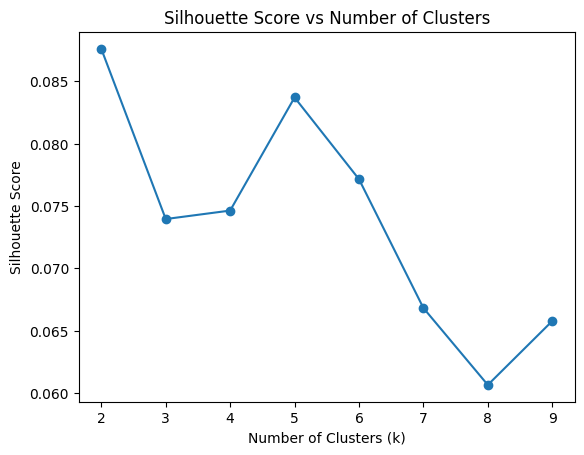

In [23]:
silhouette_scores = []
K = range(2, 10)   # try 2 to 20 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    temp_labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, temp_labels)
    silhouette_scores.append(score)

optimal_k = 5 #K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

plt.plot(K, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()


#### *Cluster mapping*

In [24]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(embeddings)


In [25]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_clusteres = df_lemmatized.copy()
df_clusteres["cluster"] = kmeans.fit_predict(embeddings)


In [26]:
df_clustered = df_lemmatized.reset_index(drop=True)
df_clustered["cluster"] = labels
df_clustered['cluster'].value_counts()


cluster
4    265
1    255
0    182
3    122
2     55
Name: count, dtype: int64

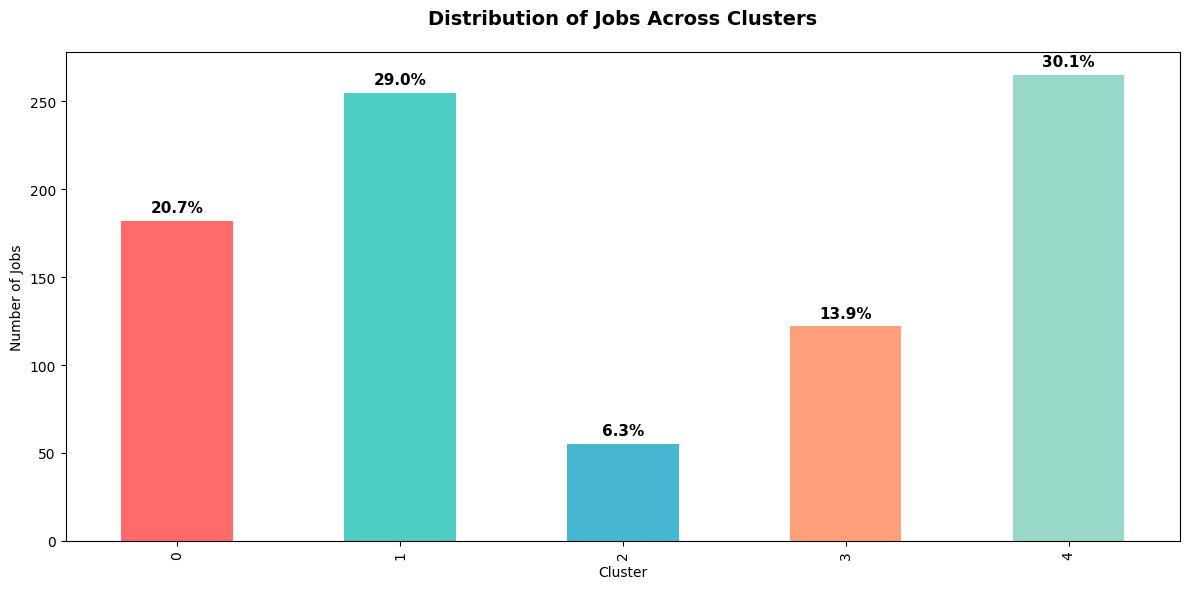

In [27]:
plt.figure(figsize=(12, 6))
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
total = cluster_counts.sum()

ax = cluster_counts.plot(
    kind='bar',
    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'],
    figsize=(12, 6)
)

# Add percentage labels on top of bars
for i, v in enumerate(cluster_counts):
    percentage = (v / total) * 100
    ax.text(i, v + 5, f'{percentage:.1f}%', ha='center', fontsize=11, weight='bold')

plt.ylabel('Number of Jobs')
plt.xlabel('Cluster')
plt.title('Distribution of Jobs Across Clusters', fontsize=14, weight='bold', pad=20)
plt.tight_layout()
plt.show()


## Topic Modeling

In [28]:
docs = df_clustered["lemmatized_text"].astype(str).tolist()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

topic_model = BERTopic(
    embedding_model=embedding_model,
    language="english",
    min_topic_size=30,        # avoid tiny noisy topics
    calculate_probabilities=False,
    verbose=True
)

In [29]:
topics, _ = topic_model.fit_transform(docs)

df_clustered["topic"] = topics

topic_model.get_topic_info().head(10)


2026-01-28 17:05:12,131 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

2026-01-28 17:05:16,780 - BERTopic - Embedding - Completed ✓
2026-01-28 17:05:16,782 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-28 17:05:22,680 - BERTopic - Dimensionality - Completed ✓
2026-01-28 17:05:22,681 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-28 17:05:22,713 - BERTopic - Cluster - Completed ✓
2026-01-28 17:05:22,716 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-28 17:05:22,757 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,155,-1_require_comprehension_management_expression,"[require, comprehension, management, expressio...",[production manager job responsibility manage ...
1,0,240,0_control_require_operation_dexterity,"[control, require, operation, dexterity, monit...",[machine tool setter operator tender metal pla...
2,1,185,1_comprehension_write_require_expression,"[comprehension, write, require, expression, se...",[bailiff job responsibility maintain order cou...
3,2,147,2_comprehension_write_require_reasoning,"[comprehension, write, require, reasoning, exp...",[care nurse job responsibility provide nursing...
4,3,88,3_comprehension_system_reasoning_write,"[comprehension, system, reasoning, write, engi...",[engineer job responsibility research design d...
5,4,64,4_teacher_teaching_comprehension_write,"[teacher, teaching, comprehension, write, requ...",[science teacher postsecondary job responsibil...


In [30]:
topic_words = {}

for topic_id in topic_model.get_topics().keys():
    if topic_id == -1:
        continue
    words = [word for word, _ in topic_model.get_topic(topic_id)[:10]]
    topic_words[topic_id] = words

In [31]:
for t, words in topic_words.items():
    print(f"Topic {t}: {words}")

Topic 0: ['control', 'require', 'operation', 'dexterity', 'monitor', 'equipment', 'hand', 'steadiness', 'coordination', 'management']
Topic 1: ['comprehension', 'write', 'require', 'expression', 'service', 'management', 'reasoning', 'customer', 'problem', 'speech']
Topic 2: ['comprehension', 'write', 'require', 'reasoning', 'expression', 'problem', 'service', 'medicine', 'dentistry', 'biology']
Topic 3: ['comprehension', 'system', 'reasoning', 'write', 'engineering', 'design', 'require', 'problem', 'expression', 'technology']
Topic 4: ['teacher', 'teaching', 'comprehension', 'write', 'require', 'expression', 'strategy', 'teach', 'instruct', 'education']


In [32]:
cluster_topic_dist = (
    df_clustered[df_clustered["topic"] != -1]
    .groupby(["cluster", "topic"])
    .size()
    .reset_index(name="count")
    .sort_values(["cluster", "count"], ascending=[True, False])
)
cluster_topic_dist.head()



,cluster,topic,count
3,0,3,87
2,0,2,27
0,0,0,13
1,0,1,9
4,1,0,226


In [33]:

topic_model.visualize_topics()

### Cluster Naming

In [34]:
vectorizer = TfidfVectorizer(
    max_df=0.9,
    min_df=5,
    ngram_range=(1, 2)
)

X = vectorizer.fit_transform(df_clustered["lemmatized_text"])
terms = np.array(vectorizer.get_feature_names_out())

In [35]:
top_words = {}

for c in sorted(df_clustered["cluster"].unique()):
    idx = df_clustered[df_clustered["cluster"] == c].index
    tfidf_mean = X[idx].mean(axis=0)

    top_idx = np.asarray(tfidf_mean).ravel().argsort()[-10:][::-1]
    top_words[c] = terms[top_idx]

In [36]:
for c, words in top_words.items():
    print(f"Cluster {c} top words:")
    print(words, "\n")

Cluster 0 top words:
['write' 'reasoning' 'system' 'expression' 'engineering' 'design'
 'technology' 'mathematic' 'engineering technology' 'computer'] 

Cluster 1 top words:
['control' 'operation' 'dexterity' 'equipment' 'hand' 'monitor'
 'hand steadiness' 'steadiness' 'operation monitor' 'precision'] 

Cluster 2 top words:
['teacher' 'teaching' 'write' 'teach' 'instruct' 'responsibility teach'
 'strategy' 'include teacher' 'learn' 'course'] 

Cluster 3 top words:
['write' 'medicine' 'dentistry' 'medicine dentistry' 'therapy' 'reasoning'
 'expression' 'service' 'counseling' 'psychology'] 

Cluster 4 top words:
['write' 'expression' 'service' 'management' 'reasoning' 'speech'
 'resource' 'personnel' 'personnel resource' 'sale'] 



In [37]:
top_words_df = pd.DataFrame({
    'Cluster': list(top_words.keys()),
    'Top Words': [', '.join(words) for words in top_words.values()]
})

display(top_words_df)

,Cluster,Top Words
0,0,"write, reasoning, system, expression, engineer..."
1,1,"control, operation, dexterity, equipment, hand..."
2,2,"teacher, teaching, write, teach, instruct, res..."
3,3,"write, medicine, dentistry, medicine dentistry..."
4,4,"write, expression, service, management, reason..."


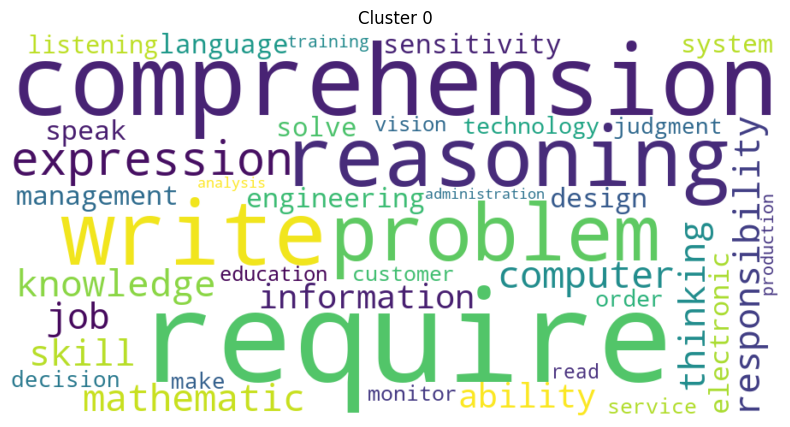

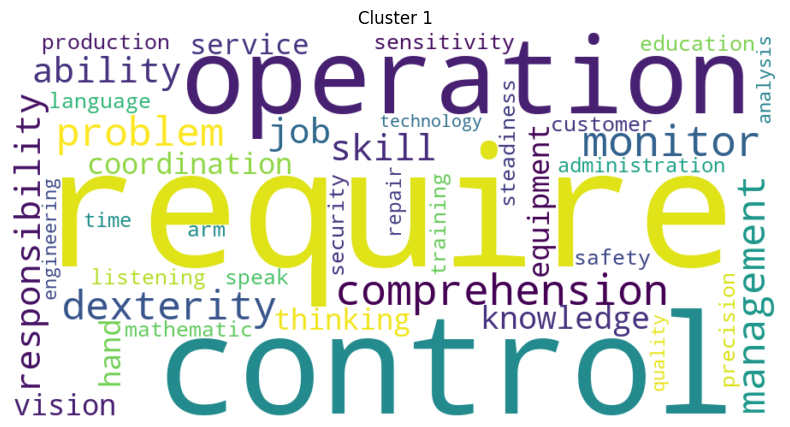

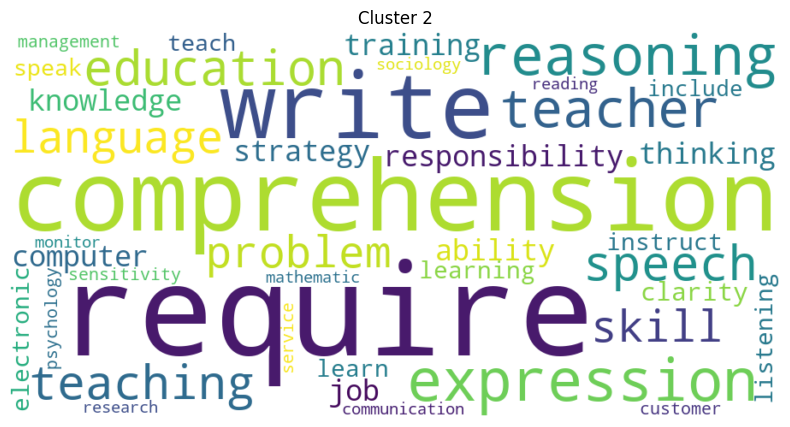

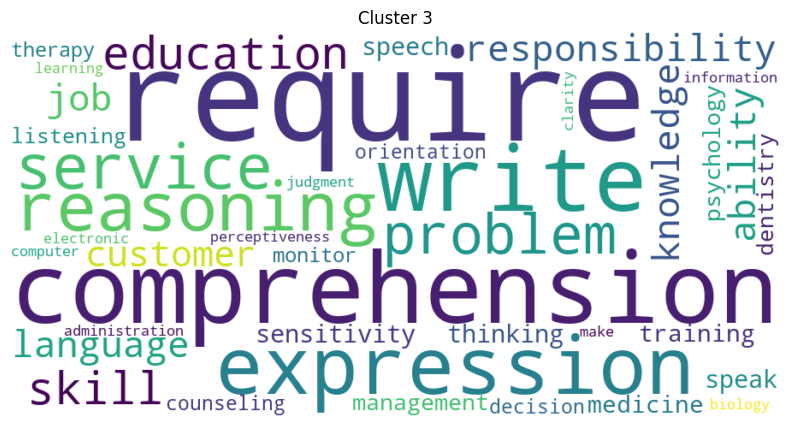

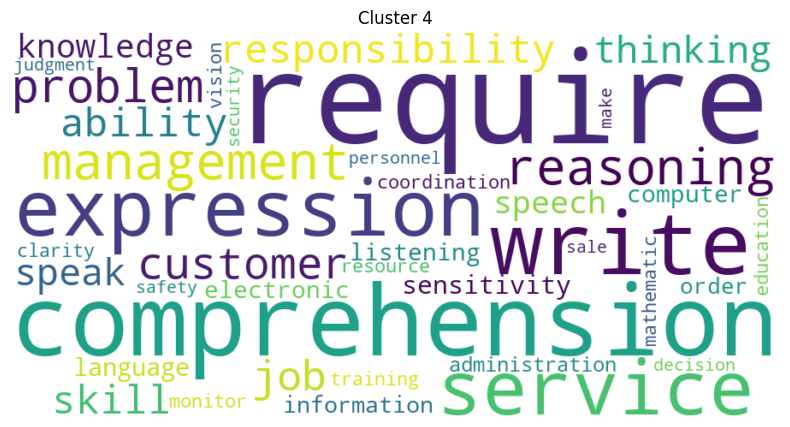

In [38]:
for c in sorted(df_clustered["cluster"].unique()):
    text = " ".join(
        df_clustered[df_clustered["cluster"] == c]["lemmatized_text"]
    )

    wc = WordCloud(
        width=900,
        height=450,
        background_color="white",
        max_words=40,
        collocations=False   # important: avoids duplicate phrases
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {c}")
    plt.show()


In [39]:
cluster_names = {
    0: "Technical & Engineering Domains",
    1: "Operational & Control Tasks",
    2: "Education & Instructional Profiles",
    3: "Healthcare & Patient Care Jobs",
    4: "Management, Sales & Administrative Services"
}

df_clustered["cluster_label"] = df_clustered["cluster"].map(cluster_names)


In [40]:
df_clustered_num = df_clustered.copy()

df_clustered_num.drop(columns=['Title','Description','Skill Profile','Knowledge Profile','Ability Profile','corpus','cleaned','lemmatized_text','cluster'], inplace=True )
df_clustered_num.head()

,Skill: Active Learning,Skill: Active Listening,Skill: Complex Problem Solving,Skill: Coordination,Skill: Critical Thinking,Skill: Equipment Maintenance,Skill: Equipment Selection,Skill: Installation,Skill: Instructing,Skill: Judgment and Decision Making,Skill: Learning Strategies,Skill: Management of Financial Resources,Skill: Management of Material Resources,Skill: Management of Personnel Resources,Skill: Mathematics,Skill: Monitoring,Skill: Negotiation,Skill: Operation and Control,Skill: Operations Analysis,Skill: Operations Monitoring,Skill: Persuasion,Skill: Programming,Skill: Quality Control Analysis,Skill: Reading Comprehension,Skill: Repairing,Skill: Science,Skill: Service Orientation,Skill: Social Perceptiveness,Skill: Speaking,Skill: Systems Analysis,Skill: Systems Evaluation,Skill: Technology Design,Skill: Time Management,Skill: Troubleshooting,Skill: Writing,Knowledge: Administration and Management,Knowledge: Administrative,Knowledge: Biology,Knowledge: Building and Construction,Knowledge: Chemistry,Knowledge: Communications and Media,Knowledge: Computers and Electronics,Knowledge: Customer and Personal Service,Knowledge: Design,Knowledge: Economics and Accounting,Knowledge: Education and Training,Knowledge: Engineering and Technology,Knowledge: English Language,Knowledge: Fine Arts,Knowledge: Food Production,Knowledge: Foreign Language,Knowledge: Geography,Knowledge: History and Archeology,Knowledge: Law and Government,Knowledge: Mathematics,Knowledge: Mechanical,Knowledge: Medicine and Dentistry,Knowledge: Personnel and Human Resources,Knowledge: Philosophy and Theology,Knowledge: Physics,Knowledge: Production and Processing,Knowledge: Psychology,Knowledge: Public Safety and Security,Knowledge: Sales and Marketing,Knowledge: Sociology and Anthropology,Knowledge: Telecommunications,Knowledge: Therapy and Counseling,Knowledge: Transportation,Ability: Arm-Hand Steadiness,Ability: Auditory Attention,Ability: Category Flexibility,Ability: Control Precision,Ability: Deductive Reasoning,Ability: Depth Perception,Ability: Dynamic Flexibility,Ability: Dynamic Strength,Ability: Explosive Strength,Ability: Extent Flexibility,Ability: Far Vision,Ability: Finger Dexterity,Ability: Flexibility of Closure,Ability: Fluency of Ideas,Ability: Glare Sensitivity,Ability: Gross Body Coordination,Ability: Gross Body Equilibrium,Ability: Hearing Sensitivity,Ability: Inductive Reasoning,Ability: Information Ordering,Ability: Manual Dexterity,Ability: Mathematical Reasoning,Ability: Memorization,Ability: Multilimb Coordination,Ability: Near Vision,Ability: Night Vision,Ability: Number Facility,Ability: Oral Comprehension,Ability: Oral Expression,Ability: Originality,Ability: Perceptual Speed,Ability: Peripheral Vision,Ability: Problem Sensitivity,Ability: Rate Control,Ability: Reaction Time,Ability: Response Orientation,Ability: Selective Attention,Ability: Sound Localization,Ability: Spatial Orientation,Ability: Speech Clarity,Ability: Speech Recognition,Ability: Speed of Closure,Ability: Speed of Limb Movement,Ability: Stamina,Ability: Static Strength,Ability: Time Sharing,Ability: Trunk Strength,Ability: Visual Color Discrimination,Ability: Visualization,Ability: Wrist-Finger Speed,Ability: Written Comprehension,Ability: Written Expression,topic,cluster_label
0,3.75,4.00,4.38,4.25,4.38,1.0,1.12,1.0,3.38,4.75,3.12,4.25,4.00,4.25,3.25,4.00,4.12,1.88,3.12,2.00,4.00,1.75,1.88,4.12,1.0,1.62,3.12,4.12,4.25,4.12,4.25,1.75,4.00,1.50,4.12,4.78,2.42,1.74,1.83,1.69,3.02,3.82,4.39,1.91,4.04,3.52,3.05,4.41,1.70,1.14,2.26,2.69,2.16,3.48,3.60,2.10,1.51,4.48,2.35,2.01,2.71,3.09,3.88,3.81,2.88,2.59,1.87,2.26,1.38,2.12,3.50,1.75,4.12,1.75,1.0,1.25,1.00,1.00,3.00,1.50,3.25,3.88,1.25,1.0,1.00,2.12,4.00,4.00,1.00,3.25,2.88,1.75,3.62,1.25,3.12,4.62,4.50,3.75,3.00,1.25,4.00,1.38,1.38,1.38,3.00,1.38,1.38,4.25,4.00,3.00,1.0,1.00,1.0,2.88,1.38,2.00,3.00,1.38,4.25,4.12,1,"Management, Sales & Administrative Services"
1,3.75,4.00,4.00,3.75,4.12,1.0,1.12,1.0,3.25,

In [41]:
# Get all columns
cols = df_clustered_num.columns.tolist()


# Remove skill_profile and corpus from their current positions
cols.remove('cluster_label')



# Insert them at positions 3 and 4
cols.insert(0, 'cluster_label')

# Reorder the dataframe
df_clustered_num = df_clustered_num[cols]

In [42]:
print(df_clustered_num.shape)   
df_clustered_num.head()

(879, 122)


,cluster_label,Skill: Active Learning,Skill: Active Listening,Skill: Complex Problem Solving,Skill: Coordination,Skill: Critical Thinking,Skill: Equipment Maintenance,Skill: Equipment Selection,Skill: Installation,Skill: Instructing,Skill: Judgment and Decision Making,Skill: Learning Strategies,Skill: Management of Financial Resources,Skill: Management of Material Resources,Skill: Management of Personnel Resources,Skill: Mathematics,Skill: Monitoring,Skill: Negotiation,Skill: Operation and Control,Skill: Operations Analysis,Skill: Operations Monitoring,Skill: Persuasion,Skill: Programming,Skill: Quality Control Analysis,Skill: Reading Comprehension,Skill: Repairing,Skill: Science,Skill: Service Orientation,Skill: Social Perceptiveness,Skill: Speaking,Skill: Systems Analysis,Skill: Systems Evaluation,Skill: Technology Design,Skill: Time Management,Skill: Troubleshooting,Skill: Writing,Knowledge: Administration and Management,Knowledge: Administrative,Knowledge: Biology,Knowledge: Building and Construction,Knowledge: Chemistry,Knowledge: Communications and Media,Knowledge: Computers and Electronics,Knowledge: Customer and Personal Service,Knowledge: Design,Knowledge: Economics and Accounting,Knowledge: Education and Training,Knowledge: Engineering and Technology,Knowledge: English Language,Knowledge: Fine Arts,Knowledge: Food Production,Knowledge: Foreign Language,Knowledge: Geography,Knowledge: History and Archeology,Knowledge: Law and Government,Knowledge: Mathematics,Knowledge: Mechanical,Knowledge: Medicine and Dentistry,Knowledge: Personnel and Human Resources,Knowledge: Philosophy and Theology,Knowledge: Physics,Knowledge: Production and Processing,Knowledge: Psychology,Knowledge: Public Safety and Security,Knowledge: Sales and Marketing,Knowledge: Sociology and Anthropology,Knowledge: Telecommunications,Knowledge: Therapy and Counseling,Knowledge: Transportation,Ability: Arm-Hand Steadiness,Ability: Auditory Attention,Ability: Category Flexibility,Ability: Control Precision,Ability: Deductive Reasoning,Ability: Depth Perception,Ability: Dynamic Flexibility,Ability: Dynamic Strength,Ability: Explosive Strength,Ability: Extent Flexibility,Ability: Far Vision,Ability: Finger Dexterity,Ability: Flexibility of Closure,Ability: Fluency of Ideas,Ability: Glare Sensitivity,Ability: Gross Body Coordination,Ability: Gross Body Equilibrium,Ability: Hearing Sensitivity,Ability: Inductive Reasoning,Ability: Information Ordering,Ability: Manual Dexterity,Ability: Mathematical Reasoning,Ability: Memorization,Ability: Multilimb Coordination,Ability: Near Vision,Ability: Night Vision,Ability: Number Facility,Ability: Oral Comprehension,Ability: Oral Expression,Ability: Originality,Ability: Perceptual Speed,Ability: Peripheral Vision,Ability: Problem Sensitivity,Ability: Rate Control,Ability: Reaction Time,Ability: Response Orientation,Ability: Selective Attention,Ability: Sound Localization,Ability: Spatial Orientation,Ability: Speech Clarity,Ability: Speech Recognition,Ability: Speed of Closure,Ability: Speed of Limb Movement,Ability: Stamina,Ability: Static Strength,Ability: Time Sharing,Ability: Trunk Strength,Ability: Visual Color Discrimination,Ability: Visualization,Ability: Wrist-Finger Speed,Ability: Written Comprehension,Ability: Written Expression,topic
0,"Management, Sales & Administrative Services",3.75,4.00,4.38,4.25,4.38,1.0,1.12,1.0,3.38,4.75,3.12,4.25,4.00,4.25,3.25,4.00,4.12,1.88,3.12,2.00,4.00,1.75,1.88,4.12,1.0,1.62,3.12,4.12,4.25,4.12,4.25,1.75,4.00,1.50,4.12,4.78,2.42,1.74,1.83,1.69,3.02,3.82,4.39,1.91,4.04,3.52,3.05,4.41,1.70,1.14,2.26,2.69,2.16,3.48,3.60,2.10,1.51,4.48,2.35,2.01,2.71,3.09,3.88,3.81,2.88,2.59,1.87,2.26,1.38,2.12,3.50,1.75,4.12,1.75,1.0,1.25,1.00,1.00,3.00,1.50,3.25,3.88,1.25,1.0,1.00,2.12,4.00,4.00,1.00,3.25,2.88,1.75,3.62,1.25,3.12,4.62,4.50,3.75,3.00,1.25,4.00,1.38,1.38,1.38,3.00,1.38,1.38,4.25,4.00,3.00,1.0,1.00,1.0,2.88,1.38,2.00,3.00,1.38,4.25,4.12,1
1,"Management, Sales & Administrative Service

In [43]:
low_ai_resistance = [
    # Knowledge
    "Knowledge: Building and Construction",
    "Knowledge: Food Production",
    "Knowledge: Mechanical",
    "Knowledge: Production and Processing",
    "Knowledge: Transportation",
    "Knowledge: Public Safety and Security",

    # Skills
    "Skill: Equipment Maintenance",
    "Skill: Equipment Selection",
    "Skill: Installation",
    "Skill: Operation and Control",
    "Skill: Operations Monitoring",
    "Skill: Repairing",

    # Abilities
    "Ability: Arm-Hand Steadiness",
    "Ability: Control Precision",
    "Ability: Depth Perception",
    "Ability: Dynamic Strength",
    "Ability: Explosive Strength",
    "Ability: Far Vision",
    "Ability: Finger Dexterity",
    "Ability: Gross Body Coordination",
    "Ability: Gross Body Equilibrium",
    "Ability: Manual Dexterity",
    "Ability: Multilimb Coordination",
    "Ability: Near Vision",
    "Ability: Night Vision",
    "Ability: Peripheral Vision",
    "Ability: Rate Control",
    "Ability: Reaction Time",
    "Ability: Speed of Limb Movement",
    "Ability: Stamina",
    "Ability: Static Strength",
    "Ability: Trunk Strength",
    "Ability: Wrist-Finger Speed"
]


In [44]:
medium_ai_resistance = [
    # Knowledge
    "Knowledge: Administration and Management",
    "Knowledge: Administrative",
    "Knowledge: Biology",
    "Knowledge: Chemistry",
    "Knowledge: Communications and Media",
    "Knowledge: Computers and Electronics",
    "Knowledge: Design",
    "Knowledge: Economics and Accounting",
    "Knowledge: Engineering and Technology",
    "Knowledge: English Language",
    "Knowledge: Fine Arts",
    "Knowledge: Foreign Language",
    "Knowledge: Geography",
    "Knowledge: History and Archeology",
    "Knowledge: Mathematics",
    "Knowledge: Medicine and Dentistry",
    "Knowledge: Physics",
    "Knowledge: Sales and Marketing",
    "Knowledge: Telecommunications",
    "Knowledge: Biology",
    "Knowledge: Chemistry",
    "Knowledge: Medicine and Dentistry",

    # Skills
    "Skill: Coordination",
    "Skill: Mathematics",
    "Skill: Monitoring",
    "Skill: Operations Analysis",
    "Skill: Programming",
    "Skill: Quality Control Analysis",
    "Skill: Reading Comprehension",
    "Skill: Science",
    "Skill: Speaking",
    "Skill: Systems Analysis",
    "Skill: Systems Evaluation",
    "Skill: Technology Design",
    "Skill: Time Management",
    "Skill: Troubleshooting",
    "Skill: Writing",

    # Abilities
    "Ability: Auditory Attention",
    "Ability: Category Flexibility",
    "Ability: Dynamic Flexibility",
    "Ability: Extent Flexibility",
    "Ability: Flexibility of Closure",
    "Ability: Glare Sensitivity",
    "Ability: Hearing Sensitivity",
    "Ability: Inductive Reasoning",
    "Ability: Information Ordering",
    "Ability: Mathematical Reasoning",
    "Ability: Memorization",
    "Ability: Number Facility",
    "Ability: Perceptual Speed",
    "Ability: Response Orientation",
    "Ability: Selective Attention",
    "Ability: Sound Localization",
    "Ability: Spatial Orientation",
    "Ability: Speech Clarity",
    "Ability: Speech Recognition",
    "Ability: Speed of Closure",
    "Ability: Visual Color Discrimination",
    "Ability: Visualization",
    "Ability: Written Comprehension",
    "Ability: Visual Color Discrimination",
    "Ability: Sound Localization",
    "Ability: Written Comprehension"
]


In [45]:
high_ai_resistance = [
    # Knowledge
    "Knowledge: Customer and Personal Service",
    "Knowledge: Education and Training",
    "Knowledge: Law and Government",
    "Knowledge: Personnel and Human Resources",
    "Knowledge: Philosophy and Theology",
    "Knowledge: Psychology",
    "Knowledge: Sociology and Anthropology",
    "Knowledge: Therapy and Counseling",

    # Skills
    "Skill: Active Learning",
    "Skill: Active Listening",
    "Skill: Complex Problem Solving",
    "Skill: Critical Thinking",
    "Skill: Instructing",
    "Skill: Judgment and Decision Making",
    "Skill: Learning Strategies",
    "Skill: Management of Financial Resources",
    "Skill: Management of Material Resources",
    "Skill: Management of Personnel Resources",
    "Skill: Negotiation",
    "Skill: Persuasion",
    "Skill: Service Orientation",
    "Skill: Social Perceptiveness",

    # Abilities
    "Ability: Deductive Reasoning",
    "Ability: Fluency of Ideas",
    "Ability: Oral Comprehension",
    "Ability: Oral Expression",
    "Ability: Originality",
    "Ability: Problem Sensitivity",
    "Ability: Time Sharing",
    "Ability: Written Expression"
]


In [46]:
numeric_cols = df_clustered_num.select_dtypes(include=[np.number]).columns


In [47]:
df_cluster_avg = (
    df_clustered_num
    .groupby("cluster_label")[numeric_cols]
    .mean()
    .reset_index()
)
df_cluster_avg

,cluster_label,Skill: Active Learning,Skill: Active Listening,Skill: Complex Problem Solving,Skill: Coordination,Skill: Critical Thinking,Skill: Equipment Maintenance,Skill: Equipment Selection,Skill: Installation,Skill: Instructing,Skill: Judgment and Decision Making,Skill: Learning Strategies,Skill: Management of Financial Resources,Skill: Management of Material Resources,Skill: Management of Personnel Resources,Skill: Mathematics,Skill: Monitoring,Skill: Negotiation,Skill: Operation and Control,Skill: Operations Analysis,Skill: Operations Monitoring,Skill: Persuasion,Skill: Programming,Skill: Quality Control Analysis,Skill: Reading Comprehension,Skill: Repairing,Skill: Science,Skill: Service Orientation,Skill: Social Perceptiveness,Skill: Speaking,Skill: Systems Analysis,Skill: Systems Evaluation,Skill: Technology Design,Skill: Time Management,Skill: Troubleshooting,Skill: Writing,Knowledge: Administration and Management,Knowledge: Administrative,Knowledge: Biology,Knowledge: Building and Construction,Knowledge: Chemistry,Knowledge: Communications and Media,Knowledge: Computers and Electronics,Knowledge: Customer and Personal Service,Knowledge: Design,Knowledge: Economics and Accounting,Knowledge: Education and Training,Knowledge: Engineering and Technology,Knowledge: English Language,Knowledge: Fine Arts,Knowledge: Food Production,Knowledge: Foreign Language,Knowledge: Geography,Knowledge: History and Archeology,Knowledge: Law and Government,Knowledge: Mathematics,Knowledge: Mechanical,Knowledge: Medicine and Dentistry,Knowledge: Personnel and Human Resources,Knowledge: Philosophy and Theology,Knowledge: Physics,Knowledge: Production and Processing,Knowledge: Psychology,Knowledge: Public Safety and Security,Knowledge: Sales and Marketing,Knowledge: Sociology and Anthropology,Knowledge: Telecommunications,Knowledge: Therapy and Counseling,Knowledge: Transportation,Ability: Arm-Hand Steadiness,Ability: Auditory Attention,Ability: Category Flexibility,Ability: Control Precision,Ability: Deductive Reasoning,Ability: Depth Perception,Ability: Dynamic Flexibility,Ability: Dynamic Strength,Ability: Explosive Strength,Ability: Extent Flexibility,Ability: Far Vision,Ability: Finger Dexterity,Ability: Flexibility of Closure,Ability: Fluency of Ideas,Ability: Glare Sensitivity,Ability: Gross Body Coordination,Ability: Gross Body Equilibrium,Ability: Hearing Sensitivity,Ability: Inductive Reasoning,Ability: Information Ordering,Ability: Manual Dexterity,Ability: Mathematical Reasoning,Ability: Memorization,Ability: Multilimb Coordination,Ability: Near Vision,Ability: Night Vision,Ability: Number Facility,Ability: Oral Comprehension,Ability: Oral Expression,Ability: Originality,Ability: Perceptual Speed,Ability: Peripheral Vision,Ability: Problem Sensitivity,Ability: Rate Control,Ability: Reaction Time,Ability: Response Orientation,Ability: Selective Attention,Ability: Sound Localization,Ability: Spatial Orientation,Ability: Speech Clarity,Ability: Speech Recognition,Ability: Speed of Closure,Ability: Speed of Limb Movement,Ability: Stamina,Ability: Static Strength,Ability: Time Sharing,Ability: Trunk Strength,Ability: Visual Color Discrimination,Ability: Visualization,Ability: Wrist-Finger Speed,Ability: Written Comprehension,Ability: Written Expression,topic
0,Education & Instructional Profiles,3.755455,3.972364,3.506182,3.247273,3.817636,1.081818,1.167455,1.004364,4.080364,3.482182,3.966000,1.708364,1.897636,2.796000,2.593091,3.670909,2.825455,1.208364,2.219818,1.716727,2.970545,1.633091,1.709455,3.999455,1.075091,2.320909,3.183636,3.451455,4.158545,2.974364,2.972000,1.677636,3.279091,1.311818,3.854182,2.984364,2.931455,2.177091,1.446545,1.914182,2.992364,3.370000,3.257455,1.944364,1.982909,4.369091,1.998182,4.386364,1.862727,1.313273,2.047091,2.459818,2.516182,2.654364,3.268364,1.638000,1.838727,2.595273,2.495818,1.887091,1.678182,3.182364,2.618000,1.994545,2.980545,2.023455,2.393455,1.749636,1.494364,2.095455,3.174000,1.331091,3.7

In [48]:
AI_WEIGHT = {
    "High": 2,
    "Medium": 1,
    "Low": 0
}


In [49]:
low_cols = set(low_ai_resistance)
medium_cols = set(medium_ai_resistance)
high_cols = set(high_ai_resistance)

def get_ai_weight(col_name):
    if col_name in high_cols:
        return AI_WEIGHT["High"]
    elif col_name in medium_cols:
        return AI_WEIGHT["Medium"]
    elif col_name in low_cols:
        return AI_WEIGHT["Low"]
    else:
        # safety net (should NOT happen if data is clean)
        return AI_WEIGHT["Medium"]


In [50]:
feature_cols = [c for c in df_cluster_avg.columns if c != "cluster_label"]

# compute weighted human-score per row
def row_ai_resistance(row):
    score = 0
    for col in feature_cols:
        score += row[col] * get_ai_weight(col)
    return score

df_cluster_avg["AI_Resistance_Score"] = df_cluster_avg.apply(row_ai_resistance, axis=1)


In [51]:
df_cluster_avg["AI_Proneness_Score"] = df_cluster_avg["AI_Resistance_Score"].max() - df_cluster_avg["AI_Resistance_Score"]


In [52]:
cluster_scores = (
    df_cluster_avg.groupby("cluster_label")[["AI_Resistance_Score", "AI_Proneness_Score"]]
      .mean()
      .sort_values("AI_Proneness_Score", ascending=False)
)

cluster_scores


,AI_Resistance_Score,AI_Proneness_Score
cluster_label,,
Operational & Control Tasks,280.875725,62.371184
"Management, Sales & Administrative Services",310.890528,32.356381
Technical & Engineering Domains,330.664835,12.582074
Healthcare & Patient Care Jobs,342.059918,1.186991
Education & Instructional Profiles,343.246909,0.000000


In [53]:
scaler = MinMaxScaler()
cluster_scores["AI_Proneness_Normalized"] = scaler.fit_transform(
    cluster_scores[["AI_Proneness_Score"]]
)


cluster_scores

,AI_Resistance_Score,AI_Proneness_Score,AI_Proneness_Normalized
cluster_label,,,
Operational & Control Tasks,280.875725,62.371184,1.000000
"Management, Sales & Administrative Services",310.890528,32.356381,0.518771
Technical & Engineering Domains,330.664835,12.582074,0.201729
Healthcare & Patient Care Jobs,342.059918,1.186991,0.019031
Education & Instructional Profiles,343.246909,0.000000,0.000000


In [54]:
import pickle
import json
import os

os.makedirs("artifacts", exist_ok=True)

# save models
pickle.dump(kmeans_final, open("artifacts/kmeans.pkl", "wb"))
pickle.dump(vectorizer, open("artifacts/vectorizer.pkl", "wb"))

# save scores & labels
cluster_scores.to_csv("artifacts/cluster_scores.csv")

json.dump(
    cluster_names,
    open("artifacts/cluster_names.json", "w")
)

print("Artifacts saved successfully.")


Artifacts saved successfully.
